In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will use probabilistic programming to analyze a population survey that was taken by several thousand households mothers living in Rwanda in 2015.  

Specifically, we will try to find the probability that a family lives in urban or rural setting, based on the amount of time it takes them to get to a water source.

In [154]:
fields = ['v115', 'v025']
df = pd.read_stata('RWIR70FL.DTA', columns=fields)

In [155]:
# Drop strings and convert "water on premises" to 1 minute
df.v115.replace({'on premises':1.0, 'not a de jure resident':999.0, "don't know":999.0}, inplace=True) 
df.dropna(subset=['v115'], inplace=True)
df['v115'] = df['v115'].astype(int)
df = df[df.v115<999] # remove values over 998 

In [156]:
df.v025.value_counts()

rural    9904
urban    3334
Name: v025, dtype: int64

In [157]:
df.v025.replace({'rural':0,'urban':1}, inplace=True)

In [158]:
print("Correlation between 'time to water source' and rural-urban household:")
df.v025.corr(df.v115)

Correlation between 'time to water source' and rural-urban household:


-0.3239807593401245

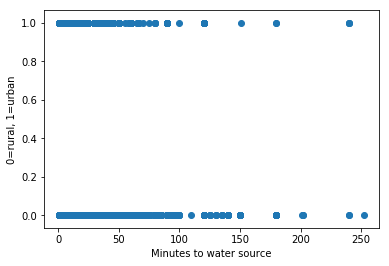

In [159]:
plt.scatter(df.v115, df.v025)
plt.ylabel('0=rural, 1=urban')
plt.xlabel('Minutes to water source')
plt.show()

It appears that the more time you need to get to a water source, the more likely it is that you live in a rural setting. 

* Let's try to calculate the probabilities of this relationship.

In [160]:
# reduce size of dataset due to limited coputational power. Maintail same averages in the process
sample = df.sample(frac=0.1, replace=False, random_state=222)

In [161]:
print(df[df.v025==0]['v115'].mean())
print(df[df.v025==1]['v115'].mean())

33.93517770597738
13.349430113977204


In [162]:
print(sample[sample.v025==0]['v115'].mean())
print(sample[sample.v025==1]['v115'].mean())

32.94438827098079
13.429850746268658


# Probabiliy of livng in urban or rural setting based on time-to-water-source

In [165]:
t_to_water = np.array(sample.v115) # final grade
urban_rural = np.array(sample.v025)  # failed past classes (1) or not (0)?

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.01, testval=0) # when τ=0.01, the variance is 1/τ, which is 100 
    alpha = pm.Normal("alpha", mu=0, tau=0.01, testval=0)
    #p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*t_to_water + alpha)))
    p = pm.Deterministic("p", pm.math.sigmoid((-1)*beta*t_to_water + alpha*(-1))) #return 1 / (1 + math.exp(-x))

In [166]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=urban_rural)
    trace = pm.sample(3000, tune=1000, njobs=1)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:11<00:00, 335.07it/s]


In [167]:
pm.summary(burned_trace, varnames=['alpha','beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.082506,0.102599,0.002416,-0.285984,0.111788,1340.349970,0.999827
beta,0.055837,0.004820,0.000108,0.046324,0.064809,1474.624912,0.999923


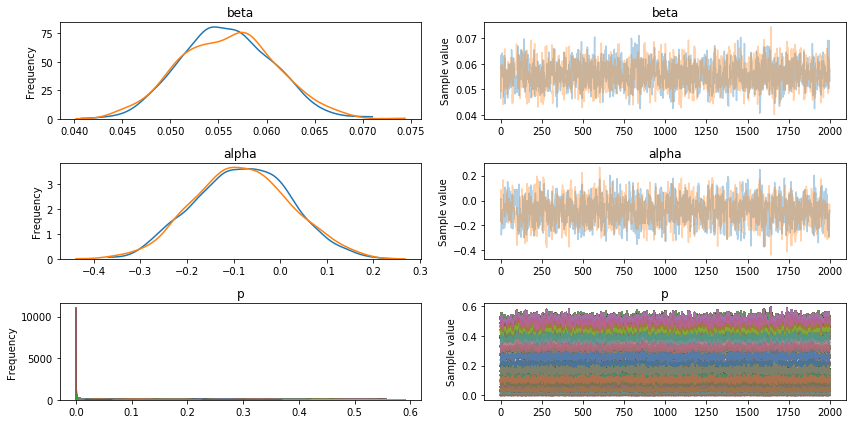

In [168]:
pm.traceplot(burned_trace)
plt.show()

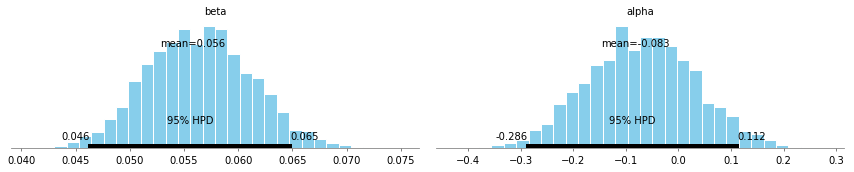

In [169]:
pm.plot_posterior(burned_trace,
                  varnames=['beta','alpha'], 
                  color='#87ceeb')
plt.show()

In [170]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(0, 60, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

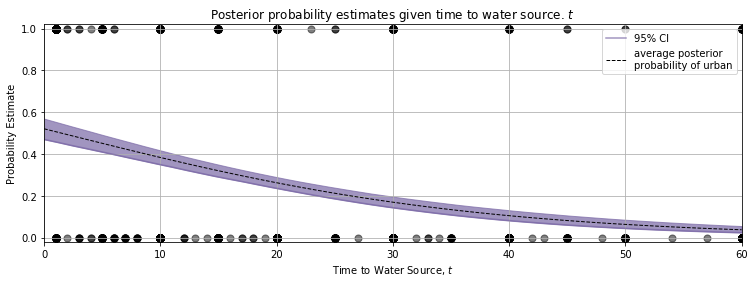

In [183]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(12.5, 4))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of urban")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(t_to_water, urban_rural, color="k", s=50, alpha=0.5)
plt.xlabel("Time to Water Source, $t$")

plt.ylabel("Probability Estimate")
plt.title("Posterior probability estimates given time to water source. $t$")
plt.grid()
plt.show()

When it takes 2 or more minutes to get to water source, it is always more likely to be a rural setting. Only if it takes 1 minute, it is more likely to be an urban setting. 

That is why the probability of coming from an urban setting is above 50% only at the 1-minute mark

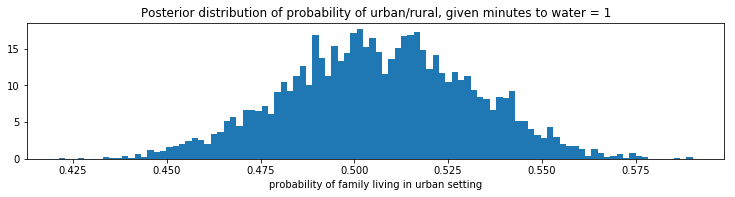

In [185]:
plt.figure(figsize=(12.5, 2.5))

prob_1 = logistic(1, beta_samples, alpha_samples)

# plt.xlim(0.995, 1) # expand this if need be
plt.hist(prob_1, bins=100, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of urban/rural, given minutes to water = 1")
plt.xlabel("probability of family living in urban setting");